In [ ]:
# This cell extracts newspaper names/counts from American Stories tar files

import csv
import re
import os
import tarfile
from collections import Counter, defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from glob import glob
import pandas as pd

# Try to use orjson (much faster), fall back to stdlib json
try:
    import orjson as json
    def load_json(f):
        return json.loads(f.read())
except ImportError:
    import json
    def load_json(f):
        return json.load(f)

# Optional: progress bar
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable, **kwargs):
        return iterable

data_folder = "data/American Stories Raw"

# Pre-compile regex patterns (avoid recompilation per call)
NAME_PATTERN = re.compile(r'^([^(\[]+)')
LOCATION_PATTERN = re.compile(r'\(([^)]+)\)')
BRACKET_PATTERN = re.compile(r'\[([^\]]+)\]')
BRACKET_REMOVE_PATTERN = re.compile(r'\s*\[[^\]]+\]')
YEAR_DIGITS_PATTERN = re.compile(r'\d{4}.*')
FILENAME_YEAR_PATTERN = re.compile(r'(\d{4})')

# State abbreviation mapping (unchanged)
STATE_ABBREV = {
    'al': 'Alabama', 'ak': 'Alaska', 'az': 'Arizona', 'ar': 'Arkansas',
    'ca': 'California', 'co': 'Colorado', 'ct': 'Connecticut', 'de': 'Delaware',
    'fl': 'Florida', 'ga': 'Georgia', 'hi': 'Hawaii', 'id': 'Idaho',
    'il': 'Illinois', 'in': 'Indiana', 'ia': 'Iowa', 'ks': 'Kansas', 'kan': 'Kansas',
    'ky': 'Kentucky', 'la': 'Louisiana', 'me': 'Maine', 'md': 'Maryland',
    'ma': 'Massachusetts', 'mi': 'Michigan', 'mn': 'Minnesota', 'ms': 'Mississippi',
    'mo': 'Missouri', 'mt': 'Montana', 'ne': 'Nebraska', 'nv': 'Nevada',
    'nh': 'New Hampshire', 'nj': 'New Jersey', 'nm': 'New Mexico', 'ny': 'New York',
    'nc': 'North Carolina', 'nd': 'North Dakota', 'oh': 'Ohio', 'ohio': 'Ohio',
    'ok': 'Oklahoma', 'or': 'Oregon', 'pa': 'Pennsylvania', 'ri': 'Rhode Island',
    'sc': 'South Carolina', 's.c': 'South Carolina',
    'sd': 'South Dakota', 's.d': 'South Dakota',
    'tn': 'Tennessee', 'tx': 'Texas', 'ut': 'Utah',
    'vt': 'Vermont', 'va': 'Virginia', 'wa': 'Washington', 'wv': 'West Virginia',
    'wi': 'Wisconsin', 'wis': 'Wisconsin', 'wy': 'Wyoming',
    'd.c': 'District of Columbia'
}

def extract_info(entry):
    """Extract newspaper name, town, and state from a title string."""
    name_match = NAME_PATTERN.match(entry)
    name = name_match.group(1).strip().rstrip('.') if name_match else entry
    
    location_match = LOCATION_PATTERN.search(entry)
    town, state = '', ''
    
    if location_match:
        location = location_match.group(1)
        bracket_match = BRACKET_PATTERN.search(location)
        state_abbr = None
        
        if bracket_match:
            state_abbr = bracket_match.group(1).lower().rstrip('.')
            location = BRACKET_REMOVE_PATTERN.sub('', location)
        
        loc_parts = [p.strip() for p in location.split(',')]
        
        if state_abbr:
            town = loc_parts[0] if loc_parts else ''
            state = STATE_ABBREV.get(state_abbr, state_abbr.upper())
        elif len(loc_parts) >= 2:
            town = loc_parts[0]
            state_part = loc_parts[-1].lower().rstrip('.').strip()
            state_part = YEAR_DIGITS_PATTERN.sub('', state_part).strip()
            state = STATE_ABBREV.get(state_part, state_part.upper())
    
    return {'name': name, 'town': town, 'state': state}

def process_tar_file(file_path):
    """Process a single tar file and return (year, {title: (count, issn, lccn)})."""
    match = FILENAME_YEAR_PATTERN.search(os.path.basename(file_path))
    year = match.group(1) if match else None
    
    if not year:
        return None, {}
    
    # Store {title: [count, issn, lccn]}
    data = {}
    
    with tarfile.open(file_path, "r:gz") as tar:
        for member in tar:
            if not member.isfile() or not member.name.endswith(".json"):
                continue
            
            f = tar.extractfile(member)
            if not f:
                continue
                
            try:
                content = load_json(f)
                lccn_obj = content.get('lccn', {})
                title = lccn_obj.get("title", "")
                if title:
                    title_lower = title.lower()
                    if title_lower in data:
                        data[title_lower][0] += 1
                    else:
                        issn = lccn_obj.get("issn", "")
                        lccn = lccn_obj.get("lccn", "")
                        data[title_lower] = [1, issn, lccn]
            except Exception:
                continue
    
    return year, data

def main():
    tar_files = sorted(glob(os.path.join(data_folder, "*.tar.gz")))
    print(f"Found {len(tar_files)} tar files to process")
    
    if not tar_files:
        print("No tar files found!")
        return
    
    # Process files in parallel
    # Store {title: {'years': {year: count}, 'issn': str, 'lccn': str}}
    all_data = defaultdict(lambda: {'years': Counter(), 'issn': '', 'lccn': ''})
    years = set()
    
    # Use number of threads (I/O bound, so can use more than CPU count)
    max_workers = min(16, len(tar_files))
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_tar_file, f): f for f in tar_files}
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing tar files"):
            year, data = future.result()
            if year:
                years.add(year)
                for title, (count, issn, lccn) in data.items():
                    all_data[title]['years'][year] += count
                    # Store issn/lccn if we don't have them yet (they're the same across years)
                    if issn and not all_data[title]['issn']:
                        all_data[title]['issn'] = issn
                    if lccn and not all_data[title]['lccn']:
                        all_data[title]['lccn'] = lccn
    
    years = sorted(years)
    print(f"\nYears found: {years}")
    
    # Build final results
    results = []
    for title, title_data in all_data.items():
        info = extract_info(title)
        info['issn'] = title_data['issn']
        info['lccn'] = title_data['lccn']
        total = 0
        year_counts = title_data['years']
        for year in years:
            c = year_counts.get(year, 0)
            info[f'{year}_count'] = c
            total += c
        info['total'] = total
        results.append(info)
    
    # Sort by total count descending
    results.sort(key=lambda x: x['total'], reverse=True)
    
    # Write to CSV
    fieldnames = ['name', 'town', 'state', 'issn', 'lccn'] + [f'{y}_count' for y in years] + ['total']
    
    with open('data/newspapers_all_years.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(results)
    
    print(f"\nCSV file created with {len(results)} unique newspapers.")
    
    # Preview top 5
    print("\nTop 5 newspapers by total count:")
    for r in results[:5]:
        year_counts_str = ", ".join(f"{y}: {r[f'{y}_count']}" for y in years if r[f'{y}_count'] > 0)
        print(f"  {r['name']} ({r['town']}, {r['state']}) - Total: {r['total']}")
        print(f"    {year_counts_str}")

if __name__ == "__main__":
    main()

    # merge duplicates

    df = pd.read_csv('data/newspapers_all_years.csv')
    count_cols = [c for c in df.columns if c.endswith('_count')]
    agg = {c: 'sum' for c in count_cols}
    agg.update({c: 'first' for c in ['name', 'town', 'state', 'lccn', 'total']})
    result = df.groupby('issn', as_index=False).agg(agg)
    result = result[df.columns].sort_values('total', ascending=False)
    result.to_csv('data/newspapers_all_years_updated.csv', index=False)

    # filter down to only newspapers that have 3 years of 10+ scans

    import pandas as pd

    df = pd.read_csv('data/newspapers_all_years_updated.csv')
    year_cols = [c for c in df.columns if c.endswith('_count') and c != 'total']
    df = df[(df[year_cols] >= 10).sum(axis=1) >= 3]
    df.to_csv('data/newspapers_all_years_updated.csv', index=False)

Found 22 tar files to process


Processing tar files: 100%|██████████| 22/22 [36:21<00:00, 99.15s/it]   


Years found: ['1869', '1870', '1871', '1872', '1873', '1874', '1875', '1876', '1877', '1878', '1879', '1880', '1881', '1882', '1883', '1884', '1885', '1886', '1887', '1888', '1889', '1890']

CSV file created with 1493 unique newspapers.

Top 5 newspapers by total count:
  new-york tribune (new york, N.Y) - Total: 49609
    1869: 1876, 1870: 1391, 1871: 1547, 1872: 1394, 1873: 1631, 1874: 1462, 1875: 2329, 1876: 1323, 1877: 1829, 1878: 1551, 1879: 1373, 1880: 2424, 1881: 2733, 1882: 2727, 1883: 2843, 1884: 2434, 1885: 2149, 1886: 1935, 1887: 3288, 1888: 3453, 1889: 3920, 1890: 3997
  evening star (washington, District of Columbia) - Total: 32979
    1869: 850, 1870: 1098, 1871: 1324, 1872: 1454, 1873: 1317, 1874: 1276, 1875: 1270, 1876: 1166, 1877: 517, 1878: 1292, 1879: 1349, 1880: 1413, 1881: 1602, 1882: 1663, 1883: 1569, 1884: 1452, 1885: 1570, 1886: 1397, 1887: 1816, 1888: 1915, 1889: 2741, 1890: 2928
  alexandria gazette (alexandria, District of Columbia) - Total: 25698
    1869: 

In [ ]:
# This cell creates a sqlite database of every single article and headline in in American Stories from 1869 - 1890

import json
import tarfile
import sqlite3
from tqdm import tqdm
from glob import glob

print("Extracting all headlines and articles from raw data")

# --- Set up SQLite ---

DB_PATH = "data/newspapers.db"
con = sqlite3.connect(DB_PATH)
cur = con.cursor()

cur.executescript("""
    CREATE TABLE IF NOT EXISTS headlines (
        lccn TEXT NOT NULL,
        issn TEXT,
        year INTEGER NOT NULL,
        text TEXT NOT NULL
    );
    CREATE TABLE IF NOT EXISTS articles (
        lccn TEXT NOT NULL,
        issn TEXT,
        year INTEGER NOT NULL,
        text TEXT NOT NULL
    );
    CREATE INDEX IF NOT EXISTS idx_headlines_issn_year ON headlines(issn, year);
    CREATE INDEX IF NOT EXISTS idx_articles_issn_year ON articles(issn, year);
    CREATE INDEX IF NOT EXISTS idx_headlines_lccn_year ON headlines(lccn, year);
    CREATE INDEX IF NOT EXISTS idx_articles_lccn_year ON articles(lccn, year);
""")
con.commit()

# --- Helpers ---

def clean(text):
    return ' '.join(text.split())

# --- Process tar files ---

data_folder = "data/American Stories Raw"
BATCH_SIZE = 5000

tar_paths = sorted(glob(f"{data_folder}/*.tar.gz"))
for i, tar_path in enumerate(tar_paths, 1):
    year = int(tar_path.split("_")[-1].replace(".tar.gz", ""))

    # Skip years already processed
    cur.execute("SELECT COUNT(*) FROM headlines WHERE year = ?", (year,))
    if cur.fetchone()[0] > 0:
        print(f"Skipping {year} (already in DB)")
        continue

    headline_batch = []
    article_batch = []
    headline_count = 0
    article_count = 0

    with tarfile.open(tar_path, "r:gz") as tar:
        for member in tqdm(tar.getmembers(), desc=str(year)):
            if not member.name.endswith(".json"):
                continue
            f = tar.extractfile(member)
            if not f:
                continue
            try:
                data = json.load(f)
                lccn = data["lccn"]["lccn"]
                issn = data["lccn"].get("issn")

                for bbox in data.get("bboxes", []):
                    legible = bbox.get("legibility") == "Legible"
                    if not legible:
                        continue

                    cls = bbox.get("class")
                    text = clean(bbox["raw_text"])
                    if not text:
                        continue

                    if cls == "headline":
                        headline_batch.append((lccn, issn, year, text))
                        headline_count += 1
                    elif cls == "article":
                        article_batch.append((lccn, issn, year, text))
                        article_count += 1

                    if len(headline_batch) >= BATCH_SIZE:
                        cur.executemany("INSERT INTO headlines VALUES (?, ?, ?, ?)", headline_batch)
                        headline_batch.clear()
                    if len(article_batch) >= BATCH_SIZE:
                        cur.executemany("INSERT INTO articles VALUES (?, ?, ?, ?)", article_batch)
                        article_batch.clear()

            except Exception:
                continue

    # Flush remaining
    if headline_batch:
        cur.executemany("INSERT INTO headlines VALUES (?, ?, ?, ?)", headline_batch)
    if article_batch:
        cur.executemany("INSERT INTO articles VALUES (?, ?, ?, ?)", article_batch)
    con.commit()

    print(f"  [{i}/{len(tar_paths)}] {year}: {headline_count} headlines, {article_count} articles")

con.close()
print(f"\nDone. Database saved to {DB_PATH}")

# manually fix a few duplicates

DB_PATH = "data/newspapers.db"
con = sqlite3.connect(DB_PATH)
cur = con.cursor()

merges = {
    "2158-9062": ["2158-9054", "2158-8996", "2159-3752"],  # wichita eagle
    "2163-6346": ["2163-6362"],  # homer/claiborne guardian
    "2329-6461": ["2329-6437"],  # great falls tribune
}

for target, sources in merges.items():
    for old in sources:
        for table in ["headlines", "articles"]:
            cur.execute(f"UPDATE {table} SET issn = ? WHERE issn = ?", (target, old))
            print(f"{table}: {old} -> {target} ({cur.rowcount} rows)")

con.commit()
con.close()
print("\nDone.")

Extracting all headlines and articles from raw data


1869: 100%|██████████| 66034/66034 [01:56<00:00, 565.57it/s]


  [1/22] 1869: 1135946 headlines, 1379591 articles


1870: 100%|██████████| 67194/67194 [02:07<00:00, 525.13it/s]


  [2/22] 1870: 1204236 headlines, 1417604 articles


1871: 100%|██████████| 66913/66913 [03:40<00:00, 302.92it/s]


  [3/22] 1871: 1253488 headlines, 1462424 articles


1872: 100%|██████████| 74855/74855 [04:16<00:00, 292.31it/s]


  [4/22] 1872: 1348830 headlines, 1582426 articles


1873: 100%|██████████| 81392/81392 [04:26<00:00, 305.38it/s]


  [5/22] 1873: 1306054 headlines, 1540705 articles


1874: 100%|██████████| 82443/82443 [04:37<00:00, 296.95it/s]


  [6/22] 1874: 1335999 headlines, 1597809 articles


1875: 100%|██████████| 88245/88245 [04:55<00:00, 298.82it/s]


  [7/22] 1875: 1417171 headlines, 1659414 articles


1876: 100%|██████████| 86278/86278 [04:49<00:00, 297.84it/s]


  [8/22] 1876: 1388119 headlines, 1580538 articles


1877: 100%|██████████| 85369/85369 [04:37<00:00, 307.59it/s]


  [9/22] 1877: 1359610 headlines, 1528052 articles


1878: 100%|██████████| 85013/85013 [03:35<00:00, 393.82it/s]


  [10/22] 1878: 1510408 headlines, 1662975 articles


1879: 100%|██████████| 86250/86250 [03:52<00:00, 371.08it/s]


  [11/22] 1879: 1481515 headlines, 1640938 articles


1880: 100%|██████████| 91876/91876 [05:35<00:00, 273.88it/s]


  [12/22] 1880: 1562031 headlines, 1814745 articles


1881: 100%|██████████| 92302/92302 [05:04<00:00, 302.93it/s]


  [13/22] 1881: 1562424 headlines, 1880854 articles


1882: 100%|██████████| 93311/93311 [05:29<00:00, 283.18it/s]


  [14/22] 1882: 1725714 headlines, 2034432 articles


1883: 100%|██████████| 102540/102540 [06:53<00:00, 248.26it/s]


  [15/22] 1883: 1956828 headlines, 2196771 articles


1884: 100%|██████████| 107638/107638 [06:34<00:00, 273.11it/s]


  [16/22] 1884: 2042226 headlines, 2228043 articles


1885: 100%|██████████| 113351/113351 [07:00<00:00, 269.32it/s]


  [17/22] 1885: 2187809 headlines, 2458639 articles


1886: 100%|██████████| 124463/124463 [06:47<00:00, 305.35it/s]


  [18/22] 1886: 2359975 headlines, 2626893 articles


1887: 100%|██████████| 135612/135612 [05:46<00:00, 391.54it/s]


  [19/22] 1887: 2561942 headlines, 2837283 articles


1888: 100%|██████████| 133079/133079 [06:58<00:00, 318.17it/s]


  [20/22] 1888: 2638800 headlines, 2885925 articles


1889: 100%|██████████| 138785/138785 [07:37<00:00, 303.07it/s]


  [21/22] 1889: 2842748 headlines, 3047331 articles


1890: 100%|██████████| 149708/149708 [08:09<00:00, 305.62it/s]


  [22/22] 1890: 3117015 headlines, 3206594 articles

Done. Database saved to data/newspapers.db


In [ ]:
# This cell categorizes and counts headlines by topic for every newspaper for each year, saving it to "topic_counts.json"

import json
import re
import sqlite3
from collections import Counter

DB_PATH = "data/newspapers.db"

TOPIC_DICTIONARY = {
    "politics_elections": ["vote", "voter", "election", "ballot", "candidate", "party", "democrat", "republican", "campaign", "convention", "nominate", "poll", "ticket", "caucus", "primary"],
    "congress_government": ["congress", "senate", "house", "bill", "law", "passed", "veto", "president", "cabinet", "session", "committee", "amendment", "act", "senator", "representative"],
    "courts_law": ["court", "judge", "trial", "jury", "lawyer", "case", "verdict", "guilty", "sentence", "appeal", "supreme", "justice", "plaintiff", "defendant", "lawsuit"],
    "labor_workers": ["labor", "wage", "strike", "worker", "union", "factory", "employ", "hours", "boss", "mill", "mine", "miner", "coal", "iron", "shop"],
    "business_commerce": ["trade", "market", "price", "sell", "buy", "stock", "firm", "company", "merchant", "goods", "store", "profit", "business", "commercial", "dealer"],
    "finance_money": ["bank", "money", "gold", "silver", "coin", "dollar", "debt", "bond", "loan", "credit", "currency", "treasury", "mint", "panic", "deposit"],
    "railroads_transportation": ["railroad", "rail", "train", "depot", "freight", "passenger", "track", "line", "station", "route", "fare", "car", "engine", "express", "trunk"],
    "agriculture_farming": ["farm", "farmer", "crop", "wheat", "corn", "cattle", "harvest", "land", "acre", "grain", "wool", "cotton", "hog", "market", "price"],
    "immigration_foreign": ["immigrant", "foreign", "chinese", "irish", "german", "alien", "native", "citizen", "naturalize", "emigrant", "passport", "steamer", "arrival"],
    "crime_police": ["murder", "arrest", "police", "thief", "robbery", "prison", "criminal", "crime", "officer", "stolen", "gang", "mob", "riot", "lynch", "jail"],
    "_baseline_english": [
        "the", "a", "an", "this", "that", "these", "those",
        "and", "or", "but", "for", "with", "from", "by", "at", "on", "in", "to", "of",
        "he", "she", "it", "they", "we", "his", "her", "their", "who", "what",
        "is", "are", "was", "were", "be", "been", "have", "has", "had", "will", "would",
        "said", "says", "made", "came", "went", "took", "gave", "found", "left",
        "man", "men", "woman", "city", "state", "country", "day", "year", "time",
        "new", "old", "great", "last", "first", "two", "three", "one", "all", "more",
        "today", "yesterday", "here", "there", "now", "after", "before", "over", "about"
    ],
}

TERM_TO_TOPICS = {}
for topic, terms in TOPIC_DICTIONARY.items():
    for term in terms:
        TERM_TO_TOPICS.setdefault(term, []).append(topic)

def tokenize(text):
    return re.findall(r'[a-z]+', text.lower())

def count_topics_in_headlines(headlines):
    counts = Counter()
    total = 0
    for headline in headlines:
        for token in tokenize(headline):
            total += 1
            for topic in TERM_TO_TOPICS.get(token, []):
                counts[topic] += 1
    return dict(counts), total

def calculate_ocr_grade(baseline_hits, total_tokens):
    if total_tokens == 0:
        return 0.0
    baseline_rate = baseline_hits / total_tokens
    EXPECTED_BASELINE_RATE = 0.30
    grade = min(1.0, baseline_rate / EXPECTED_BASELINE_RATE)
    return round(grade, 3)

def main():
    con = sqlite3.connect(DB_PATH)
    cur = con.cursor()

    # Get all distinct years
    cur.execute("SELECT DISTINCT year FROM headlines ORDER BY year")
    years = [row[0] for row in cur.fetchall()]

    all_results = {}

    for year in years:
        print(f"Processing {year}...")

        # Group headlines by issn for this year
        cur.execute("SELECT issn, text FROM headlines WHERE year = ?", (year,))

        papers = {}
        for issn, text in cur:
            if issn is None:
                continue
            papers.setdefault(issn, []).append(text)

        year_results = {}
        for issn, headlines in papers.items():
            topic_counts, total_tokens = count_topics_in_headlines(headlines)

            baseline_hits = topic_counts.pop("_baseline_english", 0)
            ocr_grade = calculate_ocr_grade(baseline_hits, total_tokens)

            year_results[issn] = {
                "topic_counts": topic_counts,
                "total_headlines": len(headlines),
                "total_tokens": total_tokens,
                "baseline_hits": baseline_hits,
                "ocr_grade": ocr_grade,
                "normalized_counts": {
                    topic: round((count / total_tokens) * 1000 / max(ocr_grade, 0.1), 2)
                    for topic, count in topic_counts.items()
                } if total_tokens > 0 and topic_counts else {}
            }

        all_results[str(year)] = year_results

    con.close()

    # Print OCR quality summary
    print("\n=== OCR Quality Summary ===")
    for year in sorted(all_results.keys()):
        print(f"\n{year}:")
        for issn, stats in sorted(all_results[year].items(), key=lambda x: x[1]["ocr_grade"], reverse=True):
            grade_pct = stats["ocr_grade"] * 100
            print(f"  {issn}: {grade_pct:.1f}% readable ({stats['baseline_hits']}/{stats['total_tokens']} baseline words)")

    with open("data/topic_counts.json", "w") as out:
        json.dump(all_results, out, indent=2)

    print(f"\nDone. Processed {len(years)} years -> topic_counts.json")

if __name__ == "__main__":
    main()

Processing 1869...
Processing 1870...
Processing 1871...
Processing 1872...
Processing 1873...
Processing 1874...
Processing 1875...
Processing 1876...
Processing 1877...
Processing 1878...
Processing 1879...
Processing 1880...
Processing 1881...
Processing 1882...
Processing 1883...
Processing 1884...
Processing 1885...
Processing 1886...
Processing 1887...
Processing 1888...
Processing 1889...
Processing 1890...

=== OCR Quality Summary ===

1869:
  2472-789X: 100.0% readable (88/265 baseline words)
  2375-7582: 96.0% readable (159/552 baseline words)
  2379-6332: 93.2% readable (4645/16618 baseline words)
  2333-2921: 85.6% readable (311/1211 baseline words)
  2767-438X: 84.9% readable (4052/15900 baseline words)
  2333-4541: 83.7% readable (270/1075 baseline words)
  2379-3082: 82.9% readable (4899/19692 baseline words)
  2374-6041: 82.9% readable (2173/8735 baseline words)
  2166-1774: 82.8% readable (47217/190115 baseline words)
  2373-2377: 82.6% readable (2637/10639 baseline wo

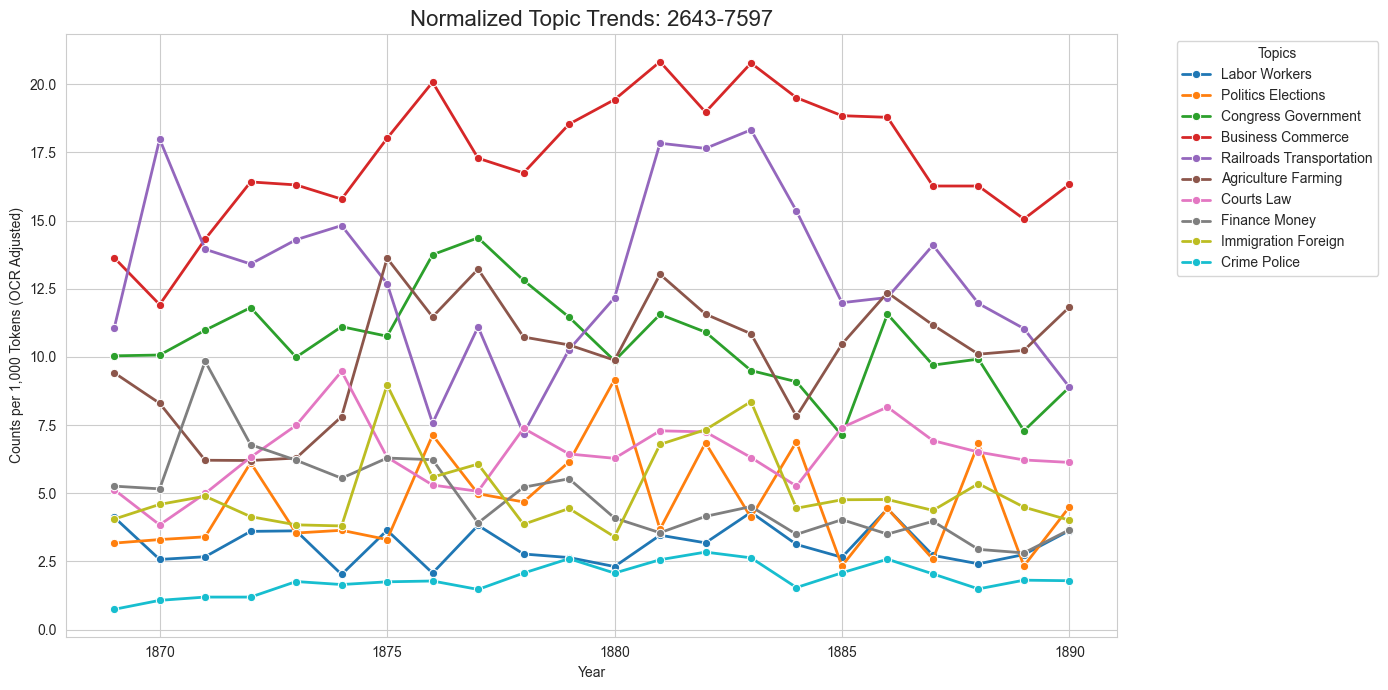

In [ ]:
# This cell visualizes topic counts for a target paper

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data (assuming it's in a file named 'data.json')
with open('data/topic_counts.json', 'r') as f:
    data = json.load(f)

def plot_normalized_trends(json_data, target_paper="2643-7597"):
    rows = []
    
    # Iterate through each year in the JSON
    for year, papers in json_data.items():
        # Check if the specific newspaper exists for that year
        if target_paper in papers:
            paper_entry = papers[target_paper]
            
            # Access the 'normalized_counts' dictionary
            if "normalized_counts" in paper_entry:
                norm_counts = paper_entry["normalized_counts"]
                
                for topic, value in norm_counts.items():
                    rows.append({
                        "Year": int(year),
                        "Topic": topic.replace("_", " ").title(),
                        "Normalized Count": value
                    })
    
    # Create DataFrame
    df = pd.DataFrame(rows)
    
    if df.empty:
        print(f"No data found for {target_paper}")
        return

    # Plotting
    plt.figure(figsize=(14, 7))
    sns.set_style("whitegrid")
    
    # Create the line plot
    plot = sns.lineplot(
        data=df, 
        x="Year", 
        y="Normalized Count", 
        hue="Topic", 
        marker="o",
        linewidth=2
    )
    
    # Formatting
    plt.title(f"Normalized Topic Trends: {target_paper.title()}", fontsize=16)
    plt.ylabel("Counts per 1,000 Tokens (OCR Adjusted)")
    plt.xlabel("Year")
    
    # Move legend outside the plot area
    plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_normalized_trends(data)

In [3]:
# match our newspapers from Melissa Dell onto Rowell's

import csv
import html
import re
import unicodedata
from thefuzz import fuzz, process
import json

# Configuration
FUZZY_THRESHOLD = 80  # Adjust this threshold as needed (0-100)

# Special case mappings for known location mismatches
# Format: (town, state_first_letter) in newspapers_all_years -> (town, state_first_letter) in master
LOCATION_OVERRIDES = {
    ('alexandria', 'd'): ('alexandria', 'v'),  # Alexandria Gazette: DC -> Virginia
}

def load_csv(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        return list(reader)

def normalize(text):
    """Normalize text for comparison."""
    if text is None:
        return ""
    return text.strip().lower()

def strip_court_house(text):
    """Remove 'c.h.' (court house) suffix from a normalized string."""
    return re.sub(r'\s*c\.?\s*h\.?\s*$', '', text).strip()

def normalize_unicode(text):
    """Decode HTML entities and remove diacritics."""
    if text is None:
        return ""
    # Decode HTML entities like &amp; -> & and &#39; -> '
    text = html.unescape(text)
    # Manual fix for known encoding issue
    text = text.replace('phå"nix', 'phenix')
    # Normalize to NFD, then remove combining characters (accents/diacritics)
    normalized = unicodedata.normalize('NFD', text)
    return ''.join(c for c in normalized if unicodedata.category(c) != 'Mn')

def remove_the(text):
    """Remove 'the' from beginning of newspaper name."""
    if text is None:
        return ""
    text = text.strip()
    if text.lower().startswith('the '):
        return text[4:]
    return text

def remove_town_from_name(name, town):
    """Remove town name from newspaper name, handling special characters."""
    if not name or not town:
        return name
    # Create pattern that matches town with optional special chars between words
    # e.g., "new york" matches "new-york", "new york", "new_york", etc.
    town_words = town.lower().split()
    pattern = r'[\s\-_]*'.join(re.escape(word) for word in town_words)
    # Remove town from name (case insensitive), including trailing space/special chars
    result = re.sub(pattern + r'[\s\-_]*', '', name, flags=re.IGNORECASE)
    return result.strip()

def remove_daily(name):
    """Remove 'daily' from newspaper name."""
    if not name:
        return name
    result = re.sub(r'\b(daily|weekly)\b[\s\-_]*', '', name, flags=re.IGNORECASE)
    return result.strip()

def has_sufficient_yearly_counts(row, min_count=10, min_years=3):
    """Check if newspaper has at least min_count in at least min_years separate years."""
    years_meeting_threshold = 0
    for key, value in row.items():
        if key.endswith('_count'):
            try:
                count = int(value) if value else 0
                if count >= min_count:
                    years_meeting_threshold += 1
            except ValueError:
                continue
    return years_meeting_threshold >= min_years

def get_state_first_letter(state):
    """Get first letter of state, normalized."""
    if state is None or len(state.strip()) == 0:
        return ""
    return state.strip()[0].lower()

def get_lookup_keys(town, state_letter):
    """Get all lookup keys to try, including any overrides."""
    keys = [(town, state_letter)]
    original_key = (town, state_letter)
    if original_key in LOCATION_OVERRIDES:
        keys.append(LOCATION_OVERRIDES[original_key])
    return keys

def main():
    # Load both CSVs
    master = load_csv('data/master.csv')
    newspapers = load_csv('data/newspapers_all_years_updated.csv')
    
    matches = []
    unmatched_diagnostics = []
    
    # Build a lookup from master by (town, state_first_letter)
    master_by_location = {}
    for idx, row in enumerate(master):
        town = normalize(row.get('town', ''))
        state_letter = get_state_first_letter(row.get('state', ''))
        key = (town, state_letter)
        if key not in master_by_location:
            master_by_location[key] = []
        master_by_location[key].append({
            'name': normalize_unicode(row.get('newspaper_name', '')),
            'idx': idx
        })
    
    # Process each row in newspapers_all_years
    for news_row in newspapers:
        # Skip if doesn't meet yearly count threshold
        if not has_sufficient_yearly_counts(news_row):
            continue
        
        news_town = strip_court_house(normalize(news_row.get('town', '')))
        news_state_letter = get_state_first_letter(news_row.get('state', ''))
        news_name = news_row.get('name', '')
        news_issn = news_row.get('issn', '')
        # Normalize unicode before further processing
        news_name_normalized = normalize_unicode(news_name)
        # Remove "the" and town name for matching
        news_name_for_matching = remove_town_from_name(remove_the(news_name_normalized), news_row.get('town', ''))
        
        # Get all keys to try (original + any overrides)
        keys_to_try = get_lookup_keys(news_town, news_state_letter)
        
        # Check if there are newspapers in master with same town and state first letter
        matched = False
        for key in keys_to_try:
            if matched:
                break
                
            if key in master_by_location:
                candidates = master_by_location[key]
                
                if candidates:
                    candidate_names = [c['name'] for c in candidates]
                    
                    # First pass: match with "the" and town removed
                    best_match, score = process.extractOne(
                        news_name_for_matching, 
                        candidate_names, 
                        scorer=fuzz.token_sort_ratio
                    )
                    
                    if score >= FUZZY_THRESHOLD:
                        master_idx = next(c['idx'] for c in candidates if c['name'] == best_match)
                        matches.append({
                            'newspapers_all_years_name': news_name,
                            'issn': news_issn,
                            'master_name': best_match,
                            'master_id': master_idx
                        })
                        matched = True
                    else:
                        # Second pass: also remove "daily"
                        news_name_no_daily = remove_daily(news_name_for_matching)
                        
                        if news_name_no_daily and news_name_no_daily != news_name_for_matching:
                            best_match, score = process.extractOne(
                                news_name_no_daily, 
                                candidate_names, 
                                scorer=fuzz.token_sort_ratio
                            )
                            
                            if score >= FUZZY_THRESHOLD:
                                master_idx = next(c['idx'] for c in candidates if c['name'] == best_match)
                                matches.append({
                                    'newspapers_all_years_name': news_name,
                                    'issn': news_issn,
                                    'master_name': best_match,
                                    'master_id': master_idx
                                })
                                matched = True
        
        # If no match found, still add the row with empty master_name
        if not matched:
            matches.append({
                'newspapers_all_years_name': news_name,
                'issn': news_issn,
                'master_name': '',
                'master_id': ''
            })
            
            # Collect diagnostic info for unmatched papers
            keys_to_try = get_lookup_keys(news_town, news_state_letter)
            all_candidates = []
            town_found = False
            for key in keys_to_try:
                if key in master_by_location:
                    town_found = True
                    all_candidates.extend(master_by_location[key])
            
            unmatched_diagnostics.append({
                'name': news_name,
                'town': news_row.get('town', ''),
                'state': news_row.get('state', ''),
                'issn': news_issn,
                'lccn': news_row.get('lccn', ''),
                'town_found': town_found,
                'candidates': all_candidates
            })
    
    # Write output
    with open('data/matches.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=['newspapers_all_years_name', 'issn', 'master_name', 'master_id'])
        writer.writeheader()
        writer.writerows(matches)
    
    # Write unmatched diagnostics as text file
    with open('unmatched_diagnostics.txt', 'w', encoding='utf-8') as f:
        f.write("UNMATCHED NEWSPAPERS DIAGNOSTICS\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Total unmatched: {len(unmatched_diagnostics)}\n\n")
        
        for i, diag in enumerate(unmatched_diagnostics, 1):
            f.write(f"--- Entry {i} ---\n")
            f.write(f"Name:  {diag['name']}\n")
            f.write(f"Town:  {diag['town']}\n")
            f.write(f"State: {diag['state']}\n")
            f.write(f"ISSN:  {diag['issn']}\n")
            f.write(f"LCCN:  {diag['lccn']}\n")
            f.write(f"Town found in master: {'Yes' if diag['town_found'] else 'No'}\n")
            if diag['candidates']:
                f.write("Master candidates in town:\n")
                for candidate in diag['candidates']:
                    f.write(f"  - {candidate['name']} (master_id: {candidate['idx']})\n")
            else:
                f.write("Master candidates in town: (none)\n")
            f.write("\n")
    
    matched_count = sum(1 for m in matches if m['master_name'])
    unmatched_count = len(matches) - matched_count
    print(f"Found {matched_count} matches and {unmatched_count} unmatched. Output written to data/matches.csv")
    print(f"Unmatched diagnostics written to unmatched_diagnostics.txt")

def manual_matches():
    # Read manual matches from JSON
    with open('data/manual_matches.json', 'r', encoding='utf-8') as f:
        manual_matches_list = json.load(f)

    # Read existing matches
    with open('data/matches.csv', 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        rows = list(reader)

    # Build lookup of manual matches by lowercase name
    manual = {
        entry['newspapers_all_years_name'].lower(): (entry['master_name'], entry['master_id'])
        for entry in manual_matches_list
    }

    updated = 0
    for row in rows:
        key = row['newspapers_all_years_name'].lower()
        if key in manual and row['master_name'] == '':
            row['master_name'] = manual[key][0]
            row['master_id'] = manual[key][1]
            updated += 1

    # Write back
    with open('data/matches.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=['newspapers_all_years_name', 'issn', 'master_name', 'master_id'])
        writer.writeheader()
        writer.writerows(rows)

    print(f"Updated {updated} rows out of {len(manual_matches_list)} manual matches.")
    if updated < len(manual_matches_list):
        matched_keys = {entry['newspapers_all_years_name'].lower() for entry in manual_matches_list}
        found_keys = {row['newspapers_all_years_name'].lower() for row in rows}
        missing = matched_keys - found_keys
        if missing:
            print(f"Names not found in matches.csv: {missing}")

if __name__ == '__main__':
    main()
    manual_matches()

Found 443 matches and 163 unmatched. Output written to data/matches.csv
Unmatched diagnostics written to unmatched_diagnostics.txt
Updated 78 rows out of 82 manual matches.
Names not found in matches.csv: {'the aegis &amp', 'conneticut western news', 'pokrok zaì\x80padu', 'pokrok zaã¬âpadu'}
